In [91]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [92]:
df = pd.read_csv("./DelayedFlights.csv")
df = df.drop(["Unnamed: 0", "Year"], axis=1)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [93]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Month                 0.000000
DayofMonth            0.000000
DayOfWeek             0.000000
DepTime               0.000000
CRSDepTime            0.000000
ArrTime               0.367108
CRSArrTime            0.000000
UniqueCarrier         0.000000
FlightNum             0.000000
TailNum               0.000258
ActualElapsedTime     0.433043
CRSElapsedTime        0.010223
AirTime               0.433043
ArrDelay              0.433043
DepDelay              0.000000
Origin                0.000000
Dest                  0.000000
Distance              0.000000
TaxiIn                0.367108
TaxiOut               0.023493
Cancelled             0.000000
CancellationCode      0.000000
Diverted              0.000000
CarrierDelay         35.588855
WeatherDelay         35.588855
NASDelay             35.588855
SecurityDelay        35.588855
LateAircraftDelay    35.588855
dtype: float64

In [94]:
# Create features
df["elapsed_time"] = df["ActualElapsedTime"] - df["CRSElapsedTime"]
df["taxi_time"] = df["TaxiOut"] - df["TaxiIn"]
df["total_delay"] = df["ArrDelay"] + df["DepDelay"]

In [95]:
df["is_delay"] = df["DepDelay"].apply(lambda x: 1 if x >= 15 else 0)

array([[<AxesSubplot: title={'center': 'Month'}>]], dtype=object)

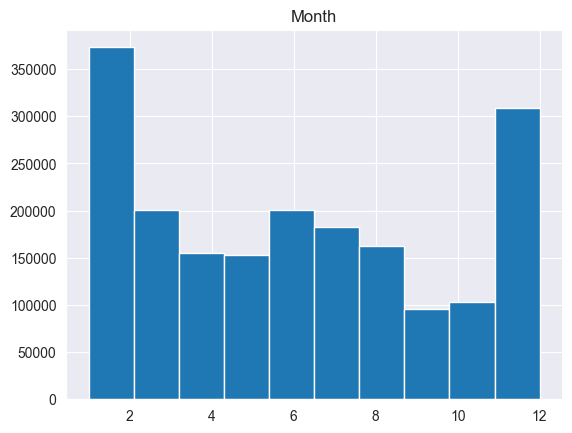

In [96]:
df.hist(column='Month')

In [97]:
df["Cancelled"].value_counts()

0    1936125
1        633
Name: Cancelled, dtype: int64

In [98]:
df["Diverted"].value_counts()

0    1929004
1       7754
Name: Diverted, dtype: int64

In [99]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,elapsed_time,taxi_time,total_delay,is_delay
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN,-22.0,4.0,-6.0,0
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN,-17.0,5.0,21.0,1
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN,6.0,14.0,22.0,0
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0,0.0,7.0,68.0,1
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN,-14.0,6.0,36.0,1


<AxesSubplot: >

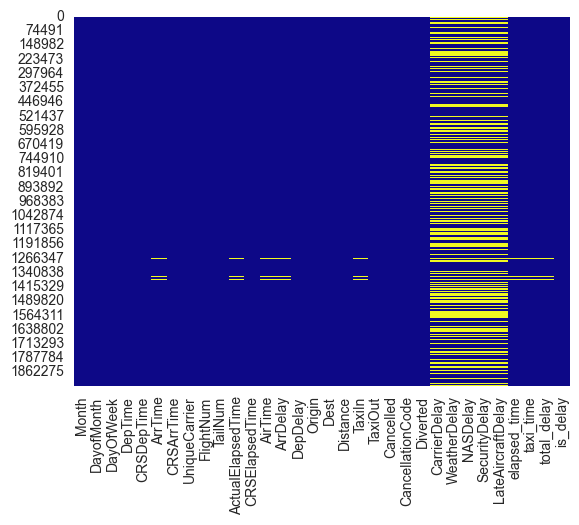

In [100]:
sns.heatmap(df.isnull(),cbar=False,cmap='plasma')

There were only a tiny fraction of flights that were cancelled.
A small proportion of flights were diverted.

In [101]:
df = df[df["Diverted"] == 0]
df = df[df["Cancelled"] == 0]

In [102]:
df.corr().style.background_gradient(cmap='bwr_r', vmin = -1, vmax = 1)

/var/folders/b4/hxnhvc455q7ghygxjmpyr9rw0000gn/T/ipykernel_51974/2028797118.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='bwr_r', vmin = -1, vmax = 1)


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,elapsed_time,taxi_time,total_delay,is_delay
Month,1.000000,0.058982,0.000050,-0.008141,-0.011640,0.001327,0.001127,-0.000547,0.002684,0.006596,0.000860,-0.000897,0.004234,0.005207,0.019257,0.002303,nan,nan,0.000420,0.006611,0.011441,-0.003066,0.004953,-0.016037,-0.004593,0.001606,-0.009325
DayofMonth,0.058982,1.000000,0.017080,0.001015,0.001018,0.000979,0.000728,-0.005860,-0.000880,-0.000234,-0.000244,0.004129,0.005278,-0.000055,-0.003072,-0.002132,nan,nan,-0.000947,0.000916,0.005644,-0.000308,0.009100,-0.002710,-0.000961,0.004741,-0.002081
DayOfWeek,0.000050,0.017080,1.000000,0.022140,0.027234,0.010960,0.017950,-0.009711,0.003072,0.004747,0.004738,0.006123,0.008720,0.007975,0.008583,-0.010421,nan,nan,0.010215,0.005654,-0.006628,0.004665,0.008839,-0.006773,-0.013031,0.007468,0.000920
DepTime,-0.008141,0.001015,0.022140,1.000000,0.881730,0.459503,0.711802,-0.024901,-0.047040,-0.044564,-0.054831,0.127017,0.139449,-0.055837,-0.011847,0.030501,nan,nan,-0.051948,0.005307,0.022530,-0.015273,0.169453,-0.012487,0.033450,0.134627,0.150560
CRSDepTime,-0.011640,0.001018,0.027234,0.881730,1.000000,0.397218,0.710465,-0.054957,-0.034925,-0.026302,-0.036582,0.044447,0.059457,-0.029311,-0.032229,0.011472,nan,nan,-0.107337,-0.009338,-0.032701,-0.017064,0.167734,-0.037308,0.022393,0.052331,0.095553
ArrTime,0.001327,0.000979,0.010960,0.459503,0.397218,1.000000,0.620066,-0.013734,-0.013595,-0.012653,-0.017684,-0.050948,-0.052843,-0.027552,0.040029,0.001634,nan,nan,-0.083981,-0.029860,0.032395,-0.007417,-0.037949,-0.004542,-0.012573,-0.052486,0.038569
CRSArrTime,0.001127,0.000728,0.017950,0.711802,0.710465,0.620066,1.000000,-0.060159,0.033203,0.039718,0.025907,0.043078,0.054121,0.024064,0.013949,0.037797,nan,nan,-0.096156,-0.005033,0.009227,-0.013349,0.131467,-0.025331,0.031338,0.049003,0.080815
FlightNum,-0.000547,-0.005860,-0.009711,-0.024901,-0.054957,-0.013734,-0.060159,1.000000,-0.322283,-0.335865,-0.341250,0.061266,0.052151,-0.356703,-0.003865,0.015439,nan,nan,0.055712,0.067488,0.015405,-0.002809,-0.052708,0.040671,0.016179,0.057534,0.056757
ActualElapsedTime,0.002684,-0.000880,0.003072,-0.047040,-0.034925,-0.013595,0.033203,-0.322283,1.000000,0.971122,0.976660,0.068130,0.018492,0.952980,0.166348,0.289568,nan,nan,0.009962,0.004066,0.177135,0.005720,-0.034204,0.167290,0.219070,0.044632,-0.007963
CRSElapsedTime,0.006596,-0.000234,0.004747,-0.044564,-0.026302,-0.012653,0.039718,-0.335865,0.971122,1.000000,0.986086,-0.015676,0.006835,0.981967,0.099693,0.123454,nan,nan,0.026586,-0.016478,0.046964,0.006104,-0.011584,-0.072761,0.083234,-0.004838,-0.016960


## Try to do train test split

In [105]:
w = np.random.rand(5, 1)
trdata = df[[
    "is_delay",
    "FlightNum",
    # "Month",
    # "DayofMonth",
    # "DayOfWeek",
    "DepTime",
    "CRSElapsedTime",
    "CRSArrTime",
    "ActualElapsedTime",
    "Distance",
    "TaxiIn",
    "TaxiOut"
]]
trdata = trdata.dropna()
trdata = trdata.reset_index()
label = trdata["is_delay"]
trdata = trdata.drop("is_delay", axis=1)

#### XGBoost to train the model
Is it over-fitting?

In [106]:

X_train, X_test, y_train, y_test = train_test_split(trdata, label, train_size=0.5, shuffle=True)
bst = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred = bst.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels = [True, False]))

/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        True       0.68      1.00      0.81    660116
       False       0.00      0.00      0.00    304070

    accuracy                           0.68    964186
   macro avg       0.34      0.50      0.41    964186
weighted avg       0.47      0.68      0.56    964186



/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=[True, False], normalize='all')
conf_mat

array([[0.68463554, 0.        ],
       [0.31536446, 0.        ]])

In [108]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty = 'none')
log.fit(X_train, y_train)

y_pred = log.predict(X_test)
print(classification_report(y_test, y_pred, labels = [True, False]))

              precision    recall  f1-score   support

        True       0.68      0.99      0.81    660116
       False       0.14      0.00      0.01    304070

    accuracy                           0.68    964186
   macro avg       0.41      0.50      0.41    964186
weighted avg       0.51      0.68      0.56    964186



In [109]:
conf_mat = confusion_matrix(y_test, y_pred, labels = [True, False], normalize = 'all')
conf_mat

array([[0.67658937, 0.00804617],
       [0.31402136, 0.0013431 ]])

### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 100, # number of trees
    max_depth= 5,       # parameters for the individual trees
    oob_score = True,   # whether or not to compute OOB score
    random_state = 22   # random state for reproducibility
)

rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, oob_score=True, random_state=22)

In [111]:
rf.oob_score_

0.6855945695068892

In [112]:
# Threshold for predicting STAY
t = 0.5

# OOB predictions for each sample
oob_preds = rf.oob_decision_function_[:,1] > t
oob_preds

array([ True,  True,  True, ...,  True,  True,  True])

In [113]:
from sklearn.metrics import classification_report

print(classification_report(y_train, oob_preds))

/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    303145
           1       0.69      1.00      0.81    661040

    accuracy                           0.69    964185
   macro avg       0.34      0.50      0.41    964185
weighted avg       0.47      0.69      0.56    964185



/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sinyou/Desktop/Projects/nus/BAProject/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
conf_mat = confusion_matrix(y_train, oob_preds, labels=[True, False], normalize='all')
conf_mat

array([[0.68559457, 0.        ],
       [0.31440543, 0.        ]])